# Image Mining
Image Mining deals with the problem of increasing the semantics of visual data by: 
- reducing its information to relevant data 
- adding to it specific information related to a model and/or to a previous knowledge, in order to facilitate its retrieval and interpretation by a machine. 




## Define an Objective for your Project

The most important step to any project is to establish a clear objective to achieve. Your objective may vary widely based on your specific use case. It will determine the type and quantity of data required for an image dataset. Remember that the purpose of our IU project is to create data-driven system or better said image-driven system. Here are some common IU objectives:

![Image of IU objectives](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/images/project_01.jpg)

- **Classification**:  Its goal is to use the raw visual data contained within an image to assign a certain conceptual label, or “class” to that image. 
- **Detection**: It is the process consisting at finding specific objects and localizing them to a certain area within an image. If you care where in an image the object is found, this is your objective.
- **Segmentation**: It is an advanced form of detection that occurs at pixel-level. Its purpose is to segment objects in an image according to their exact boundaries and separate them from each other.

For this project, since it is the "easiest" we are going to focus on and image classification project.

## Project data

Collecting and organizing a high-quality image data set is a critical step our project. This step can make or break a fledgling system. We are going to use machine learning (ML) models to classiffy our images,  but remember that ML model can produce exceptional insight, but only when they are fueled by high-quality, well-labeled, relevant data that accurately encapsulates the problem space.

In the case of data-driven projects, as ours, it is important to remember this motto: **garbage in = garbage out**.

Some desirable aspects that our dataset should have are: 
- Quantity: the dataset have a sufficient volume of images.
- Diversity: dataset's images come from a diverse set of perspectives, colors, or orientations.
- Accuracy: the dataset have relevant images and accurate labels.
- Quality: the right images in high-quality resolution are in the dataset.

Data can be collected, you can take all pictures or scrap them from internet but this is a time-demanding process, that generally implies to annotate all pictures (i.e., providing a label/class to each image). Even it can be created artificially, using novel techniques such as [GANs](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf), but this is beyond the scope of this course. However most of the time you have to deal with a dataset created by others. This will be our case.

In [33]:
# Libraries for use in a conda environment with comments on how to install them

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread

import os
import io
import glob

from sklearn.model_selection import train_test_split

# For SVM model
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from joblib import dump, load

### Get the data

In [34]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# We keep only 10000 for training and 1000 for testing
x_train = x_train[:10000, ...]
y_train = y_train[:10000]

x_test = x_test[:1000, ...]
y_test = y_test[:1000]

#### Data preparation
Sometime it is needed to organized the the data in order to work the images. For example sometimes the images are encoded in text files, or databases.

In [35]:
# To be implemented just in case

### Data exploration

An important step when dealing with an unfamiliar dataset is to understanding it. This implies to visualize it, find outliers, and know the characteristics of the image. 

Check this link: https://knowyourdata-tfds.withgoogle.com

#### Visualization

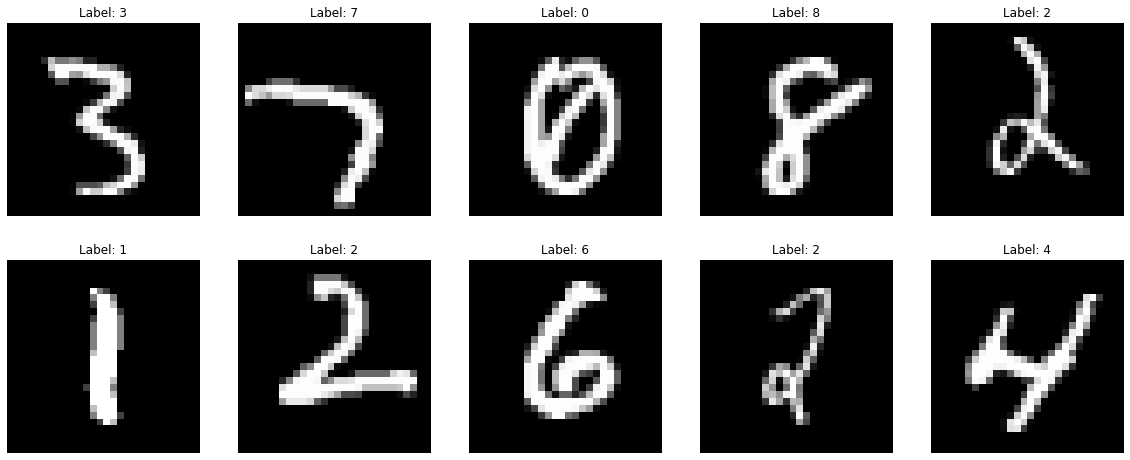

In [36]:
# Visualization of 10 random samples

num_samples = 10
rand_samples = np.random.choice(np.arange(x_train.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = x_train[rand_samples[i]]
    label = y_train[rand_samples[i]]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
    ax.imshow(im, cmap='gray')
plt.show()

#### Distribution of classes

Information about classes:
Class: 0, number of samples: 1001
Class: 1, number of samples: 1127
Class: 2, number of samples: 991
Class: 3, number of samples: 1032
Class: 4, number of samples: 980
Class: 5, number of samples: 863
Class: 6, number of samples: 1014
Class: 7, number of samples: 1070
Class: 8, number of samples: 944
Class: 9, number of samples: 978


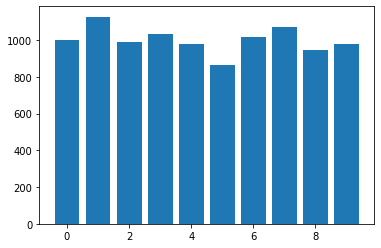

In [37]:
print('Information about classes:')

classes = np.unique(y_train)
description = np.array([(c, np.sum(y_train == c)) for c in classes])

for desc in description:
    print('Class: {}, number of samples: {}'.format(desc[0], desc[1]))

plt.bar(description[:,0], description[:,1].astype(int))
plt.show()

#### Clustering
Sometimes clustering is useful for detecting outliers in a bunch of data.

In [51]:
# Since images are 8000x28x28 whe need to vectorize our dataset, so we can use
# ML models
x_train_vec = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

# Normalize the data to 0 - 1
x_train_cluster = x_train_vec.astype(np.float32) / 255.

In [60]:
from sklearn.cluster import KMeans
from tqdm import tqdm

seed = 23 # always set a seed

# Sometimes we don't know our data and therefore we don't know the possible labels
# so we need to test many cluster numbers
n_clusters = np.arange(2, 40) # from 2 to 39

inertia_values = []
for n_cluster in tqdm(n_clusters):
  cl_model = KMeans(n_clusters=n_cluster, random_state=seed).fit(x_train_cluster)
  dump(cl_model, 'kmeans_model_pixels_n{}.joblib'.format(n_cluster)) # saving model
  inertia_values.append(cl_model.inertia_)



100%|██████████| 38/38 [13:36<00:00, 21.48s/it]


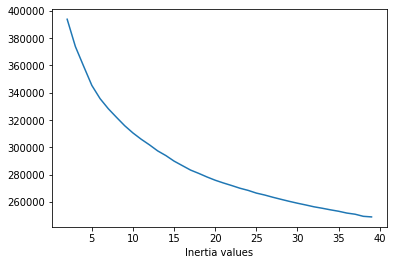

In [61]:
# This plot gives us an idea about the "natural" clusters in the data, 
# a rule of thumb says that a good choice for the number of cluster 
# is to the one in which the plot starts to bend (elbow)
plt.plot(np.arange(2,40), inertia_values)
plt.xlabel('Num. clusters')
plt.xlabel('Inertia values')
plt.show()

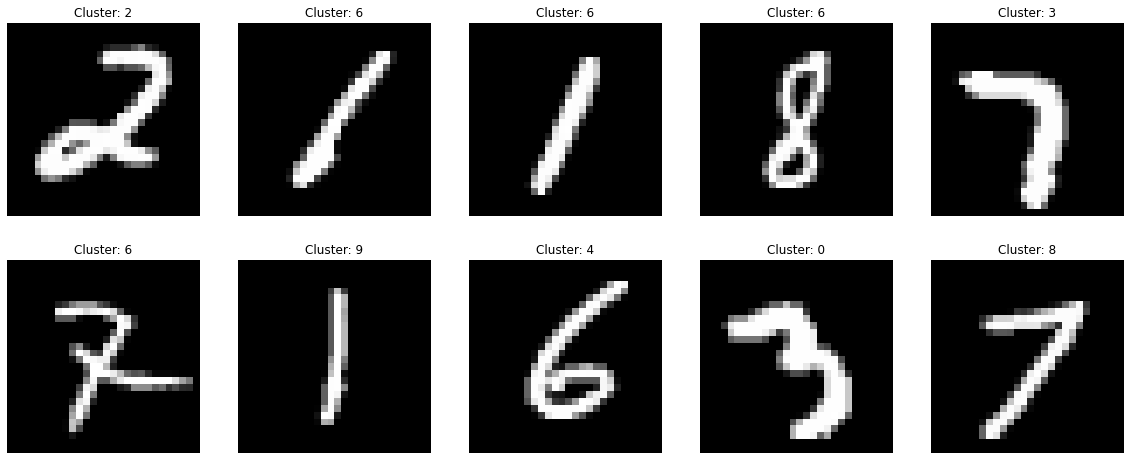

In [63]:
# As we now that there are 10 digits, we pick 10 as number of cluster
cl_model = load('kmeans_model_pixels_n{}.joblib'.format(10)) # loading model

cluster_label = cl_model.predict(x_train_cluster)


# Visualization of 10 random samples 

num_samples = 10
rand_samples = np.random.choice(np.arange(x_train_cluster.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = x_train[rand_samples[i]]
    label = cluster_label[rand_samples[i]]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Cluster: {label}")
    ax.axis('off')
    ax.imshow(im, cmap='gray')
plt.show()

Cluster 0
Class: 0, number of samples: 37
Class: 1, number of samples: 2
Class: 2, number of samples: 53
Class: 3, number of samples: 479
Class: 4, number of samples: 0
Class: 5, number of samples: 173
Class: 6, number of samples: 3
Class: 7, number of samples: 0
Class: 8, number of samples: 153
Class: 9, number of samples: 12


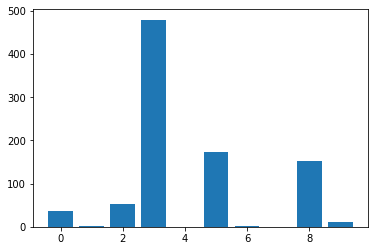

Cluster 1
Class: 0, number of samples: 77
Class: 1, number of samples: 2
Class: 2, number of samples: 23
Class: 3, number of samples: 198
Class: 4, number of samples: 1
Class: 5, number of samples: 179
Class: 6, number of samples: 9
Class: 7, number of samples: 1
Class: 8, number of samples: 401
Class: 9, number of samples: 2


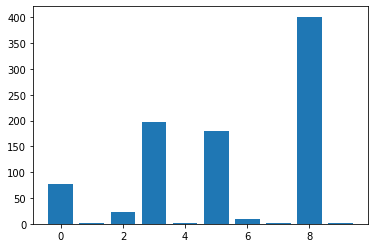

Cluster 2
Class: 0, number of samples: 7
Class: 1, number of samples: 2
Class: 2, number of samples: 548
Class: 3, number of samples: 20
Class: 4, number of samples: 4
Class: 5, number of samples: 2
Class: 6, number of samples: 8
Class: 7, number of samples: 4
Class: 8, number of samples: 3
Class: 9, number of samples: 0


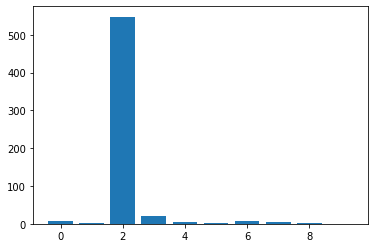

Cluster 3
Class: 0, number of samples: 1
Class: 1, number of samples: 1
Class: 2, number of samples: 4
Class: 3, number of samples: 19
Class: 4, number of samples: 182
Class: 5, number of samples: 49
Class: 6, number of samples: 0
Class: 7, number of samples: 354
Class: 8, number of samples: 20
Class: 9, number of samples: 304


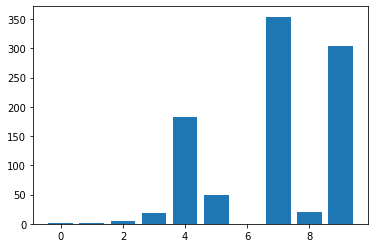

Cluster 4
Class: 0, number of samples: 33
Class: 1, number of samples: 0
Class: 2, number of samples: 18
Class: 3, number of samples: 7
Class: 4, number of samples: 10
Class: 5, number of samples: 19
Class: 6, number of samples: 614
Class: 7, number of samples: 0
Class: 8, number of samples: 15
Class: 9, number of samples: 2


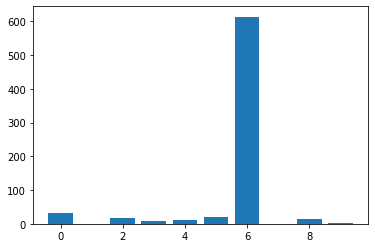

Cluster 5
Class: 0, number of samples: 626
Class: 1, number of samples: 0
Class: 2, number of samples: 6
Class: 3, number of samples: 4
Class: 4, number of samples: 0
Class: 5, number of samples: 9
Class: 6, number of samples: 11
Class: 7, number of samples: 1
Class: 8, number of samples: 4
Class: 9, number of samples: 6


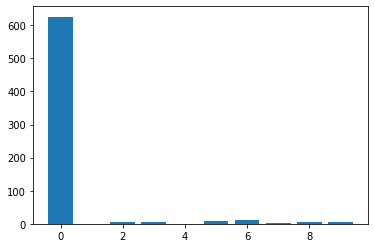

Cluster 6
Class: 0, number of samples: 0
Class: 1, number of samples: 442
Class: 2, number of samples: 44
Class: 3, number of samples: 5
Class: 4, number of samples: 23
Class: 5, number of samples: 3
Class: 6, number of samples: 3
Class: 7, number of samples: 28
Class: 8, number of samples: 23
Class: 9, number of samples: 4


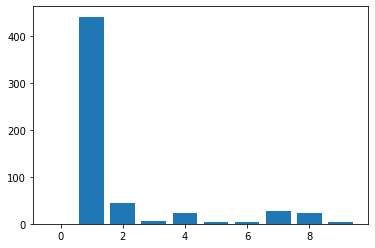

Cluster 7
Class: 0, number of samples: 12
Class: 1, number of samples: 0
Class: 2, number of samples: 18
Class: 3, number of samples: 9
Class: 4, number of samples: 329
Class: 5, number of samples: 21
Class: 6, number of samples: 85
Class: 7, number of samples: 74
Class: 8, number of samples: 25
Class: 9, number of samples: 196


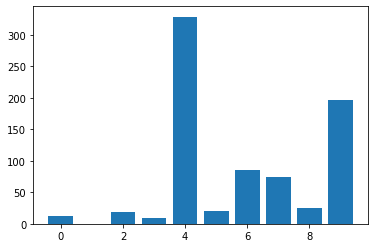

Cluster 8
Class: 0, number of samples: 0
Class: 1, number of samples: 1
Class: 2, number of samples: 6
Class: 3, number of samples: 10
Class: 4, number of samples: 227
Class: 5, number of samples: 26
Class: 6, number of samples: 0
Class: 7, number of samples: 357
Class: 8, number of samples: 28
Class: 9, number of samples: 228


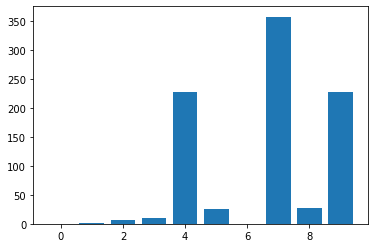

Cluster 9
Class: 0, number of samples: 4
Class: 1, number of samples: 436
Class: 2, number of samples: 100
Class: 3, number of samples: 68
Class: 4, number of samples: 35
Class: 5, number of samples: 194
Class: 6, number of samples: 90
Class: 7, number of samples: 33
Class: 8, number of samples: 70
Class: 9, number of samples: 21


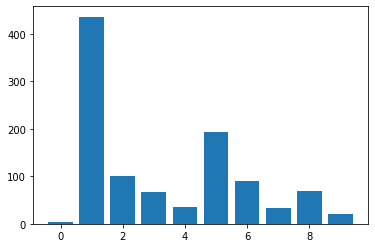

In [66]:
# As we know the natural clusters we can check if the actual labels are grouped 
# into a particular clusters, minority labels can tell us if there is a 
# significant difference among images
# For visualization you can check https://projector.tensorflow.org

actual_classes = np.unique(y_train)

for cluster in np.unique(cluster_label):

  description = np.array([(c, np.sum(y_train[cluster_label == cluster] == c)) for c in actual_classes])
  print(f'Cluster {cluster}')
  for desc in description:
    print('Class: {}, number of samples: {}'.format(desc[0], desc[1]))

  plt.bar(description[:,0], description[:,1].astype(int))
  plt.show()

# Cluster 0 - majority  Class: 3
# Cluster 1 - majority  Class: 8
# Cluster 2 - majority  Class: 2
# Cluster 3 - majority  Class: 7 (interesting)
# Cluster 4 - majority  Class: 6
# Cluster 5 - majority  Class: 0
# Cluster 6 - majority  Class: 1
# Cluster 7 - majority  Class: 4 (interesting)
# Cluster 8 - majority  Class: 7 (interesting)
# Cluster 9 - majority  Class: 1 (interesting)
# What happened with actual classes 5 and 9?

### Preprocessing
After having a clear idea of the data, it is necesarry to perform some tasks that could help to our purpose such as dealing with the outliers, denoising, histogram matching.

In [38]:
# To be implemented

## Classification using only raw pixels

During the development of a project, it is usual to test different features, and their combinations, as well as different models. In order to evaluate which is the better you have to provide some indicators (eg. error metric). This process, it is usually a try-and-error process. However, it is important to remember that a model in which you can include prior knowledge of the problem will be always a better model.

In order to make a fair comparison the sets (train, test and validation) should be the same.

Here it is an example of using al the image pixels as a features. What is the disadvantage of doing this? This is the baseline.

In [39]:
seed = 23 # It is important to use a seed

# Sometimes we need a validation set to calibrate our model
x_train, x_val, y_train, x_val = train_test_split(x_train, y_train, test_size=0.20, random_state=seed)

print('Training set shape: {}'.format(x_train.shape))
print('Validation set shape: {}'.format(x_val.shape))
print('Test set shape: {}'.format(x_test.shape))

Training set shape: (8000, 28, 28)
Validation set shape: (2000,)
Test set shape: (10000, 28, 28)


#### Model training

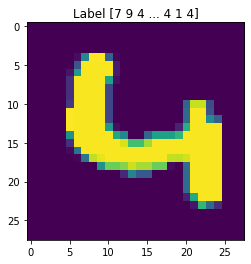

In [40]:
model = svm.SVC() # You can set the parameters

# Since images are 8000x28x28 whe need to vectorize our dataset, so we can use
# ML models
x_train_vec = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

# We checked that everythin is ok by ploting only one image
plt.imshow(x_train_vec[2,...].reshape((28,28)))
plt.title('Label {}'.format(y_train))
plt.show()



model.fit(x_train_vec, y_train) # Fitting the model

dump(model, 'svm_model_pixels.joblib') # saving model
model = load('svm_model_pixels.joblib') # loading model

#### Assesment of the model

In [43]:
# Predict the value of the digit on the test subset
x_test_vec = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

predicted = model.predict(x_test_vec)

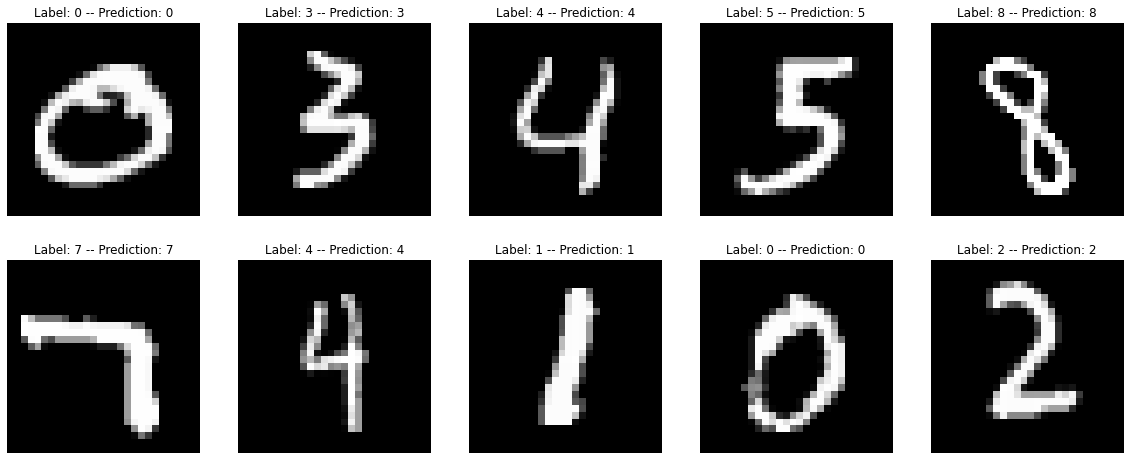

In [46]:
# Visualize some predictions

num_samples = 10

rand_samples = np.random.choice(np.arange(x_test.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = x_test[rand_samples[i]]
    label = y_test[rand_samples[i]]
    predicted_label = predicted[rand_samples[i]]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {label} -- Prediction: {predicted_label}")
    ax.axis('off')
    ax.imshow(im, cmap='gray')
plt.show()

In [47]:
print("Classification report for classifier")
print(f"{classification_report(y_test, predicted)}")

Classification report for classifier
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.94      0.96      0.95       982
           5       0.97      0.94      0.95       892
           6       0.96      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.95      0.95       974
           9       0.95      0.92      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



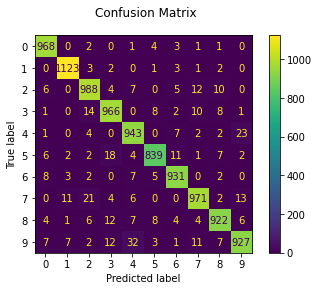

In [50]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()